In [1]:
import json
import numpy as np
import os
import pandas as pd
from IPython import display
from PIL import Image
from PIL import ImageDraw
from tqdm import tqdm

# Constants

Adapt paths to local environment!

In [2]:
data_to_check_path = "../../data/interim/data_to_check.csv"
path2datajson = "Z:/MLW/data.json"
path2output = "../../data/raw/output_final"
path_images = "Z:/MLW/zettel/"
START_POINT = 0
END_POINT = 1000
labeler_name = ""

# Data Handling

## Helper Functions

In [3]:
def load_data_json(path: str) -> pd.DataFrame:
    """ Load data.json.

    Load `data.json` file from main data ('MLW') directory.

    :param path: Path to data.json in the  '<drive>/MLW' directory.
    :return: DataFrame of imported data.
    """
    f = open(path)
    data = json.load(f)
    data = pd.DataFrame(data)
    data["length_lemma"] = [len(i) for i in data["lemma"]]
    return data

In [4]:
def load_output(path: str) -> pd.DataFrame:
    """Load and Process Output File.

    Loads and processes output file labeled by the previous visual grounding
    model. Besides coordinates of BBs, length and height are also added to 
    the DataFrame. All BBs, that start at 0.0, 0.0 are dropped and considered
    a failure.

    :param path: Path to output file.
    :return: DataFrame of imported output file. 
    """
    f: any = open(str(path),"r")
    output: list = [json.loads(d) for d in f.readlines()]
    f.close()

    id = [d["file"].split(".")[0] for d in output]
    x1 = [d["result"][0]["box"][0] for d in output]
    y1 = [d["result"][0]["box"][1] for d in output]
    x2 = [d["result"][0]["box"][2] for d in output]
    y2 = [d["result"][0]["box"][3] for d in output]

    outputs_bb = pd.DataFrame(np.array([id,x1,y1,x2,y2]).T, columns=["id","x1","y1","x2","y2"])

    outputs_bb['id'] = outputs_bb['id'].astype("int64")
    outputs_bb['x1'] = round(outputs_bb['x1'].astype("float"))
    outputs_bb['y1'] = round(outputs_bb['y1'].astype("float"))
    outputs_bb['x2'] = round(outputs_bb['x2'].astype("float"))
    outputs_bb['y2'] = round(outputs_bb['y2'].astype("float"))

    # Getting the length and height of the Bounding Boxes
    outputs_bb["length"] = outputs_bb["x2"] - outputs_bb["x1"]
    outputs_bb["height"] = outputs_bb["y2"] - outputs_bb["y1"]

    # Removing all BBs with a length larger than 1600
    outputs_bb_df = outputs_bb[(outputs_bb["length"]<1600)& (outputs_bb["height"]<1000)].copy()
    return outputs_bb_df

In [5]:
def create_dataset(path2datajson: str, path2output: str) -> pd.DataFrame:
    """Create Dataset to Label.
    
    Function to merge output and data.json datasets. Both datasets are
    first loaded and subsequently merged.
    
    :param path2datajson: Path to `data.json` file.
    :param path2output: Path to `output` file.
    :return: Merged Dataset.
    """
    datajson: pd.DataFrame = load_data_json(path2datajson)
    dataoutput: pd.DataFrame = load_output(path2output)
    data: pd.DataFrame = datajson.merge(dataoutput, on="id")
    return data

# Main

In [6]:
def get_image(path_image: str, index: int) -> ImageDraw.Draw:
    """Load Image from Data Folder.

    Load image from specicfied folder above. Path respective arguments and
    the function will return an image with a bounding box.

    :param path_image: Path to image.
    :param index: Index of image in DataFrame. Necessary to retrieve the filename.
    :return: Image with bounding box. 
    """
    file = df.iloc[index]["id"]
    image = Image.open(os.path.join(path_image, str(file)+".jpg"), mode="r")
    x1 = df.iloc[index]["x1"]
    y1 = df.iloc[index]["y1"]
    x2 = df.iloc[index]["x2"]
    y2 = df.iloc[index]["y2"]
    img = ImageDraw.Draw(image)
    img.rectangle([(x1,y1),(x2,y2)], outline ="green")
    return image

In [7]:
def display_images_with_predictions(
        df: pd.DataFrame,
        start_index: int=0,
        end_index: int=1000) -> tuple[pd.DataFrame, str]:
    """Display Images with BBs to Label.

    Function to display images including bounding boxes. Result is
    saved in the Pandas DataFrame `df`. Labeler's name is also added. 

    :param df: DataFrame, including labeled data by model (e.g. OFA).
    :param start_index: Index where the label process starts.
    :param end_index: Index where the label process ends.
    :return: Tuple of the updated DataFrame and the labeler's name.
    """
    print("If you want to leave the tool, enter stop")
    # labeler_name = input("what is your name?")
    print()
    counter_labeled = 0
    for i in tqdm(range(start_index, end_index)):
        display.clear_output(wait=True)
        id = df.iloc[i]["id"]
        lemma = df.iloc[i]["lemma"]
        print("Searching for the next Record-card: Hold on")
        if df.loc[i, "labeler"] != "":
            display.display(get_image(path_images, i))
            print(i, len(df))
            print("id: ", id)
            print("lemma: ", lemma)
            print("*"*100)
            correct_label= input("Is this record-card correct labeled?")
            print(correct_label)
            print()

            df.to_csv(data_to_check_path, index=False)
            if "'" in correct_label:
                correct_label = correct_label.replace(("'",""))
            if correct_label == "stop":
                print("*"*100)
                print("Bravo! You reviewed", counter_labeled, "record-cards \n Thank you!")
                print("*"*100)
                return df, labeler_name
            else:
                df.loc[i, "manual_check"] = correct_label
                df.loc[i, "labeler"] = labeler_name
                df.to_csv(data_to_check_path, index=False)
                counter_labeled+=1

    return df, labeler_name


## Imports

In [15]:
tail, head = os.path.split(data_to_check_path)

if os.path.exists(data_to_check_path):
    # Load existing dataset
    print("Load existing dataset")
    df = pd.read_csv(data_to_check_path)
else:
    # Create dataset basedpath2output on `data.json` and `output`
    print("Create dataset basedpath2output on `data.json` and `output`")
    df = create_dataset(
        path2datajson=path2datajson,
        path2output=path2output)
    df = df.sample(frac=1, random_state = 42).reset_index(drop=True)
    df = df.iloc[START_POINT:END_POINT,].copy()
    df.to_csv(data_to_check_path, index=False)

# Shuffle DataFrame (Random State for Reproducability)


if "labeler" not in df.columns:
    df["labeler"] = ""
    df.to_csv(data_to_check_path, index=False)

if "manual_check" not in df.columns:
    df["manual_check"] = ""
    df.to_csv(data_to_check_path, index=False)


Load existing dataset


In [16]:
si = 0
manual_check = df["manual_check"].tolist()
for i in range(len(df)):
    if type(manual_check[i]) != float:
        si = i+1
print("starting index is: ", si)

starting index is:  0


Searching for the next Record-card: Hold on


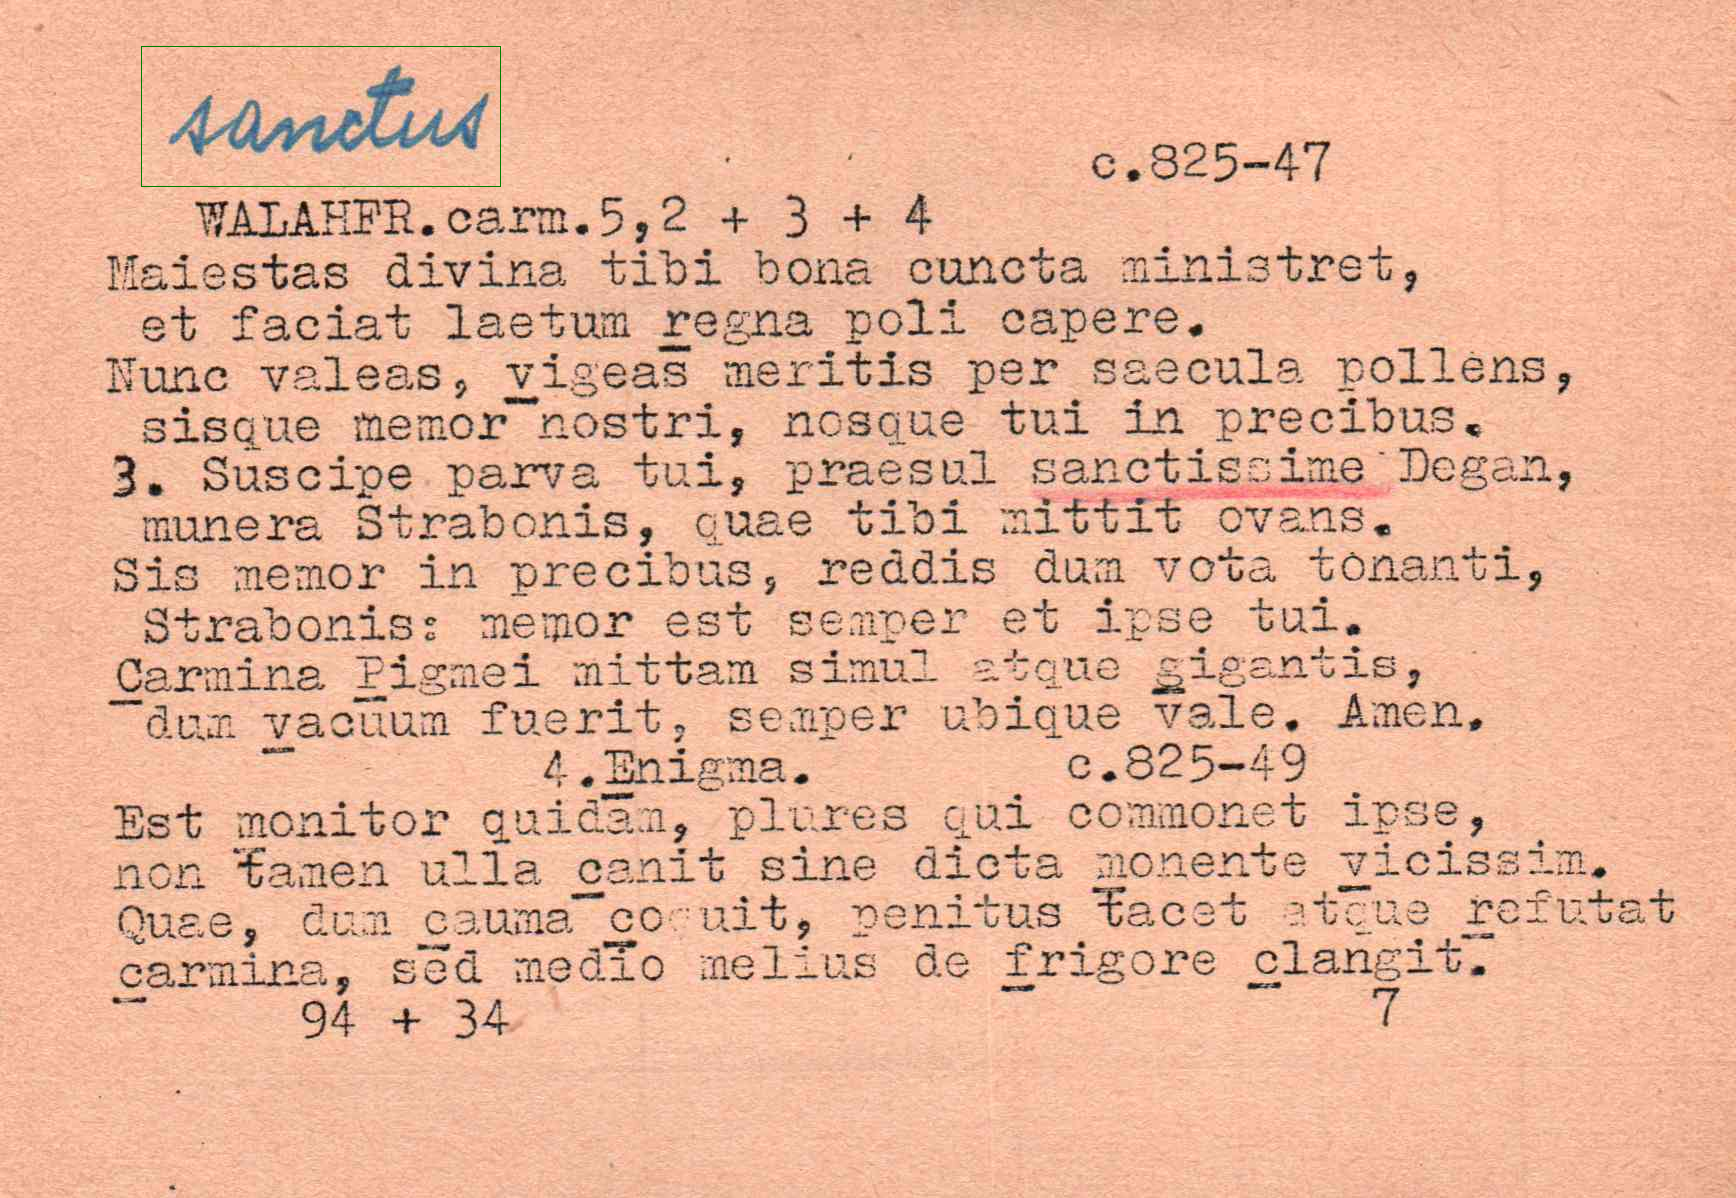

999 1000
id:  15208
lemma:  sanctus
****************************************************************************************************
Is this record-card correct labeled?y


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:28:48<00:00,  5.33s/it]

y



In [17]:
checked_data, labeler = display_images_with_predictions(pd.read_csv(data_to_check_path), start_index=si, end_index=len(df))
checked_data.to_csv(data_to_check_path, index=False)

In [18]:
df

,id,lemma,length_lemma,x1,y1,x2,y2,length,height,labeler,manual_check
0,98106,subtilis,8,156.0,74.0,479.0,187.0,323.0,113.0,NaN,NaN
1,193255,transmitto,10,130.0,12.0,609.0,155.0,479.0,143.0,NaN,NaN
2,223825,vel,3,46.0,5.0,223.0,123.0,177.0,118.0,NaN,NaN
3,84488,subiaceo,8,148.0,60.0,543.0,189.0,395.0,129.0,NaN,NaN
4,278435,lis,3,47.0,0.0,244.0,88.0,197.0,88.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
995,78111,spatium,7,160.0,100.0,551.0,215.0,391.0,115.0,NaN,NaN
996,45213,sermo,5,118.0,108.0,424.0,189.0,306.0,81.0,NaN,NaN
997,117623,supersedeo,10,105.0,10.0,636.0,156.0,531.0,146.0,NaN,NaN
998,217590,ut,2,133.0,74.0,331.0,171.0,198.0,97.0,NaN,NaN


In [12]:
df[df["lemma"]=="subtilis"]

,id,lemma,length_lemma,x1,y1,x2,y2,length,height,labeler,manual_check
0,98106,subtilis,8,156.0,74.0,479.0,187.0,323.0,113.0,,
36,98101,subtilis,8,176.0,82.0,495.0,190.0,319.0,108.0,,
923,98099,subtilis,8,72.0,12.0,657.0,116.0,585.0,104.0,,


In [20]:
data = pd.read_csv(data_to_check_path)

In [ ]:
data[data["manual_check"]=="y"]